# Demonstration & Explanations of Image Complexity Metrics

This notebook will demonstrate several calculations used to estimate the degree of complexity that an image possesses.

In [33]:
"""Imports"""

from matplotlib                 import cm, pyplot   as plt
from mpl_toolkits.axes_grid1    import ImageGrid
from numpy                      import abs, array, finfo, hstack, log2, square, sum
from os                         import makedirs
from PIL                        import Image
from pywt                       import wavedec2, wavelist

## Image samples

First, we need images that we can reasonably say are more/less complex than each other. For this purpose we will generate 6 black and white images. One solid black, one solid white, a 2x2 checker board, 4x4, 8x8, and 16x16.

In [34]:
"""Generate sample images."""

# Define output directory
output: str = "sample-images"

# Ensure directory exists
makedirs(output, exist_ok = True)

# Create solid black & white images
Image.new("L", (32, 32), 0).save(f"{output}/02-black.png")
Image.new("L", (32, 32), 255).save(f"{output}/01-white.png")

# Create checkered images
for e in range(1, 5):
    
    # Determine size of each square
    square_dim: int     = 32 // 2**e
    
    # Initialize image
    img:        Image   = Image.new("L", (32, 32))
    
    # Color the image
    for x in range(32):
        for y in range(32):
            
            img.putpixel((x, y), 255 if ((x // square_dim) + (y // square_dim)) % 2 == 0 else 0)
            
    # Save image
    img.save(f"{output}/0{e + 2}-{2**e}x{2**e}.png")

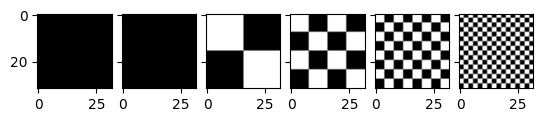

In [35]:
"""Display sample images."""

# Open images in list
images  = [Image.open(f"sample-images/{file_name}") for file_name in sorted(listdir("sample-images"))]

# Initialize plot
figure  = plt.figure()

# Initialize grid
grid    = ImageGrid(figure, 111, nrows_ncols = (1, 6), axes_pad  = 0.1)

# Add images to grid
for axis, image in zip(grid, images): axis.imshow(image, cmap = cm.gray)

# Diplsay images
plt.show()


---

# Wavelet Energy

The wavelet transform is a mathematical technique that decomposes a signal into components at various scales and positions, allowing for the analysis of both frequency and time domain characteristics simultaneously. Unlike the Fourier transform, which only provides frequency information and loses temporal localization, the wavelet transform offers the advantage of capturing localized, transient features of a signal. This makes it particularly useful for analyzing non-stationary signals, such as images, where details and patterns vary across different regions. The ability to provide multi-resolution analysis makes the wavelet transform a powerful tool for image processing~\cite{bayro2005multi}, enabling better detection of edges, textures, and other intricate structures compared to the Fourier transform.

Given an image $I$, a wavelet $w$, and decomposition level $l$:
* Perform the 2D wavelet decomposition: $\text{wavedec2}(I, w, l)$.
* For each coefficient matrix $\text{coeff}_i$, calculate the energy: $E_i = \sum_{j, k} \text{coeff}_i[j, k]^2$.
* Sum the energy of all coefficient matrices to get the total wavelet energy: $\sum_i E_i$.

$$
E = \sum_{i} \sum_{j,k} \left( \text{coeff}_i[j,k] \right)^2
$$

In [36]:
import pywt

def wavelet_energy(
        image:      array, 
        wavelet:    str = "db2", 
        level:      int = 1,
        mode:       str = "periodization"
    ) -> int:
    """# Calculate the wavelet energy of an image.

    ## Args:
        * image     (array):            Image for which the wavelet energy will be calculated.
        * wavelet   (str, optional):    Wavelet used in transform. Defaults to 'db2'.
        * level     (int, optional):    Level(s) of decomposition to perform. Defaults to 1.
        * mode      (str, optional):    Mode of padding. Options: 'zero', 'constant', 'symmetric', 
                                        'periodic', 'smooth', 'periodization', 'reflect', 
                                        'antisymmetric', 'antireflect'. Defaults to 'periodization'.

    ## Returns:
        * int:  Wavelet energy of image.
    """
    # Validate wavelet & mode arguments
    assert wavelet in wavelist(),       f"Invalid argument for wavelet: {wavelet}. Valid options: {wavelist()}"
    assert mode in pywt.Modes.modes,    f"Inavlid argument for mode: {mode}. Valid options: {pywt.Modes.modes}"

    # Perform wavelet transform & calculate energy

    # Calculate energy
    return sum(sum(square(coeff)) for coeff in wavedec2(image, wavelet=wavelet, level=level, mode=mode))

In [37]:
"""Calculate wavelet energy of sample images."""

for image in images:
    
    print(f"Wavelet evergy of {image.filename}: {wavelet_energy(image)}")

Wavelet evergy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/01-white.png: 66585600.00000001
Wavelet evergy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/02-black.png: 0.0
Wavelet evergy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/03-2x2.png: 33292800.000000015
Wavelet evergy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/04-4x4.png: 33292800.00000001
Wavelet evergy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/05-8x8.png: 33292800.00000001
Wavelet evergy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/06-16x16.png: 33292800.000000004


/tmp/ipykernel_568349/4024169959.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(sum(square(coeff)) for coeff in wavedec2(image, wavelet=wavelet, level=level, mode=mode))


---

# Wavelet Entropy

Wavelet entropy, specifically Shannon entropy, is computed by first obtaining the wavelet coefficients of an image. These coefficients are then used to calculate the probability distribution of energy across different scales. Shannon entropy is derived from this distribution, providing a measure of the image's complexity and randomness by quantifying the degree of disorder or unpredictability in the energy distribution.

Given an image $I$, wavelet $w$, and decomposition level $l$:
* Perform the 2D wavelet decomposition: $\text{wavedec2}(I, w, l)$.
* Flatten and take the absolute value of all coefficients:\\ $\text{coefficients} = \left| \text{coeff}_i[j, k]\right|$.
* Normalize the coefficients to obtain probabilities: $p_i = \frac{\text{coefficients}}{\sum_j \text{coefficients}_j}$.
* Calculate the Shannon entropy as follows, where $\epsilon$ is a small value added to avoid taking the log of zero
$$
H = -\sum_i p_i \log_2(p_i + \epsilon)
$$

In [49]:
def wavelet_entropy(
        image:      array, 
        wavelet:    str = "db2", 
        level:      int = 1,
        mode:       str = "periodization"
    ) -> float:
    """# Calculate the wavelet entropy of an image.

    ## Args:
        * image     (array):            Image for which the wavelet energy will be calculated.
        * wavelet   (str, optional):    Wavelet used in transform. Defaults to 'db2'.
        * level     (int, optional):    Level(s) of decomposition to perform. Defaults to 1.
        * mode      (str, optional):    Mode of padding. Options: 'zero', 'constant', 'symmetric', 
                                        'periodic', 'smooth', 'periodization', 'reflect', 
                                        'antisymmetric', 'antireflect'. Defaults to 'periodization'.

    ## Returns:
        * float:    Wavelet entropy of image.
    """
    # Initialize arrays to store all coefficients
    coefficients = []

    # For each level of coefficients computed...
    for coefficient in pywt.wavedec2(data = image, wavelet = wavelet, level = level, mode = mode):

        # Add their absolute values to the list
        coefficients.extend(abs(coefficient).ravel())

    # Convert them to an array
    coefficients = array(coefficients)
    
    # Normalize coefficients to probabilities
    probabilities = coefficients / sum(coefficients)
    
    # Return computed Shannon entropy
    return -sum(probabilities * log2(probabilities + finfo(float).eps))

"""Calculate wavelet entropy of sample images."""

for image in images:
    
    print(f"Wavelet entropy of {image.filename}: {wavelet_entropy(image)}")

Wavelet entropy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/01-white.png: 7.999999999999921
Wavelet entropy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/02-black.png: nan
Wavelet entropy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/03-2x2.png: 7.8772199742036575
Wavelet entropy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/04-4x4.png: 8.490833186834905
Wavelet entropy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/05-8x8.png: 9.321197233829126
Wavelet entropy of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/06-16x16.png: 9.8886920341626


/tmp/ipykernel_568349/528905907.py:33: RuntimeWarning: invalid value encountered in divide
  probabilities = coefficients / sum(coefficients)


---

# Root Mean Squared Error

RMSE has seen great success in measuring visual complexity in humans, and its speed makes it an ideal and intuitive choice for measuring image complexity. Root Mean Square Error in this case refers to the difference between the original image and the image after shrinking it by half, resizing it back to full size, computing the average of the squared pixel values of the difference, then taking the square root.

Given an image $I$ with dimensions $(H, W)$:


* Let $I_{\text{small}}$ be the image resized to $(\frac{H}{2}, \frac{W}{2})$.
* Let $I_{\text{resized}}$ be $I_{\text{small}}$ resized back to $(H, W)$.
* Compute the element-wise squared difference: $(I - I_{\text{resized}})^2$.
* Compute the mean of the squared differences.
* The $RMSE$ is then the square root of the mean.

$$
RMSE = \sqrt{\frac{1}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} \left( I_{ij} - I_{\text{resized}, ij} \right)^2}
$$

In [43]:
from numpy  import asarray, mean, ndarray, sqrt

def rmse(image: ndarray) -> float:
    """# Calculates the root mean squared error between an image and it's compressed/resized form.

    ## Args:
        * image (array):    Image input.

    ## Returns:
        * float:    Root mean squared error.
    """
    # Record image shape
    shape:  tuple = array(image).shape
    
    # Calculate & return RMSE
    return sqrt(mean(
        (image - asarray(
            image.resize((shape[1] // 2, shape[0] // 2)).resize((shape[1], shape[0]))
        )) ** 2
    ))
    
"""Calculate root mean squared error of sample images."""

for image in images:
    
    print(f"RMSE of {image.filename}: {rmse(image)}")

RMSE of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/01-white.png: 0.0
RMSE of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/02-black.png: 0.0
RMSE of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/03-2x2.png: 3.5930705879512024
RMSE of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/04-4x4.png: 4.577458355900139
RMSE of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/05-8x8.png: 7.3702315092539665
RMSE of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/06-16x16.png: 8.806957476904268


---

# Spatial Frequency

Spatial Frequency is unique from the other metrics we used in that it does not rely on edges or borders, but on a Fourier Analysis of an image. Although a contested topic and a rudimentary metric for calculating organic visual perception, the function's speed and unique properties make it a considerable choice for an experimental metric.

Given an image $I$ with dimensions $(H, W, 3)$:
* Convert the image to grayscale $I_{\text{gray}}$.
* Compute the 2D Fourier transform of the grayscale image $\mathcal{F}(I_{\text{gray}})$.
* Compute the 2D Fourier transform of each RGB channel $\mathcal{F}(I_{\text{R}})$, $\mathcal{F}(I_{\text{G}})$, $\mathcal{F}(I_{\text{B}})$.
* The spatial frequency will be the sum of the absolute values of the 2D Fourier transforms.

$$
\text{SF} = \left| \mathcal{F}(I_{\text{gray}}) \right| + \left| \mathcal{F}(I_{\text{R}}) \right| + \left| \mathcal{F}(I_{\text{G}}) \right| + \left| \mathcal{F}(I_{\text{B}}) \right|
$$

In [48]:
from numpy      import abs, asarray, ndarray, sum
from numpy.fft  import fft2
from PIL        import Image

def spatial_frequency(image: ndarray) -> float:
    """# Calculate the spatial frequency of an image.

    ## Args:
        * image (ndarray):  Image input.

    ## Returns:
        * float:    Spatial frequency of image channels (gray, red, green, blue).
    """
    image = asarray(image)
    # Calculate Fourier transform of each channel
    return sum([
        abs(fft2(asarray(Image.fromarray(image).convert("L")))),
        # abs(fft2(image[:, :, 0])),
        # abs(fft2(image[:, :, 1])),
        # abs(fft2(image[:, :, 2]))
    ])
    
"""Calculate spatial frequency of sample images."""

for image in images:
    
    print(f"Spatial frequency of {image.filename}: {spatial_frequency(image)}")

Spatial frequency of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/01-white.png: 261120.0
Spatial frequency of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/02-black.png: 0.0
Spatial frequency of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/03-2x2.png: 1102027.2537368077
Spatial frequency of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/04-4x4.png: 813446.5724589333
Spatial frequency of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/05-8x8.png: 576319.7227034313
Spatial frequency of /home/theokoles/Projects/Image-Complexity-by-Wavelet-Decomposition/sample-images/06-16x16.png: 391680.0
